# Use `while` loop

## Introduction
With the while loop we can execute a set of tasks as long as the condition is true. In this tutorial, you will learn how to use `while` loop in WorkGraph.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='bcf9e395e4bf4b64a0a705d8659c0a9c' name='default'>

## First workflow: while
Suppose we want to calculate:
```python
# start while block
n=1
while n < 100:
    n = n*2
    n = n + 3
# end while block
z = n+1
```

### Create task
We first create the tasks to do the calculation.

In [2]:
from aiida_workgraph import task, WorkGraph
from aiida.engine import calcfunction
from aiida.orm import Int

# we need a compare task for `n<100`,
# it's a normal function instead of a calcfunction
@task()
def compare(x, y):
    return x < y

# define multiply task for n*2
@calcfunction
def multiply(x, y):
    return x*y

# define add task for n+3
@calcfunction
def add(x, y):
    return x + y

# Create a WorkGraph will repeat itself based on the conditions
# then we output the result of from the context (context)
@task.graph_builder(outputs = [["context.n", "result"]])
def add_multiply_while(n, limit):
    wg = WorkGraph()
    # tell the engine that this is a `while` workgraph
    wg.workgraph_type = "WHILE"
    # the `result` of compare1 taskis used as condition
    wg.conditions = ["compare1.result"]
    # set a context variable before running.
    wg.context = {"n": n}
    wg.tasks.new(compare, name="compare1", x="{{n}}", y=Int(limit))
    multiply1 = wg.tasks.new(multiply, name="multiply1", x="{{ n }}", y=Int(2))
    add1 = wg.tasks.new(add, name="add1", y=3)
    # update the context variable
    add1.set_context({"result": "n"})
    wg.links.new(multiply1.outputs["result"], add1.inputs["x"])
    # don't forget to return the workgraph
    return wg

### Create the workflow
Now, let'use the `add_multiply_while` task in the workflow.

In [3]:
wg = WorkGraph("test_while")
while1 = wg.tasks.new(add_multiply_while, n=Int(1), limit=50)
add1 = wg.tasks.new(add, y=Int(1))
wg.links.new(while1.outputs["result"], add1.inputs["x"])
wg.submit(wait=True)

WorkGraph process created, PK: 4132


### Check status and results


In [4]:
print("State of WorkGraph:   {}".format(wg.state))
print('Result of add1   :   {}'.format(add1.outputs["result"].value))

State of WorkGraph:   FINISHED
Result of add1   :   uuid: 49ff90cd-af97-4b80-8e25-f05c621bbd2b (pk: 4162) value: 62


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

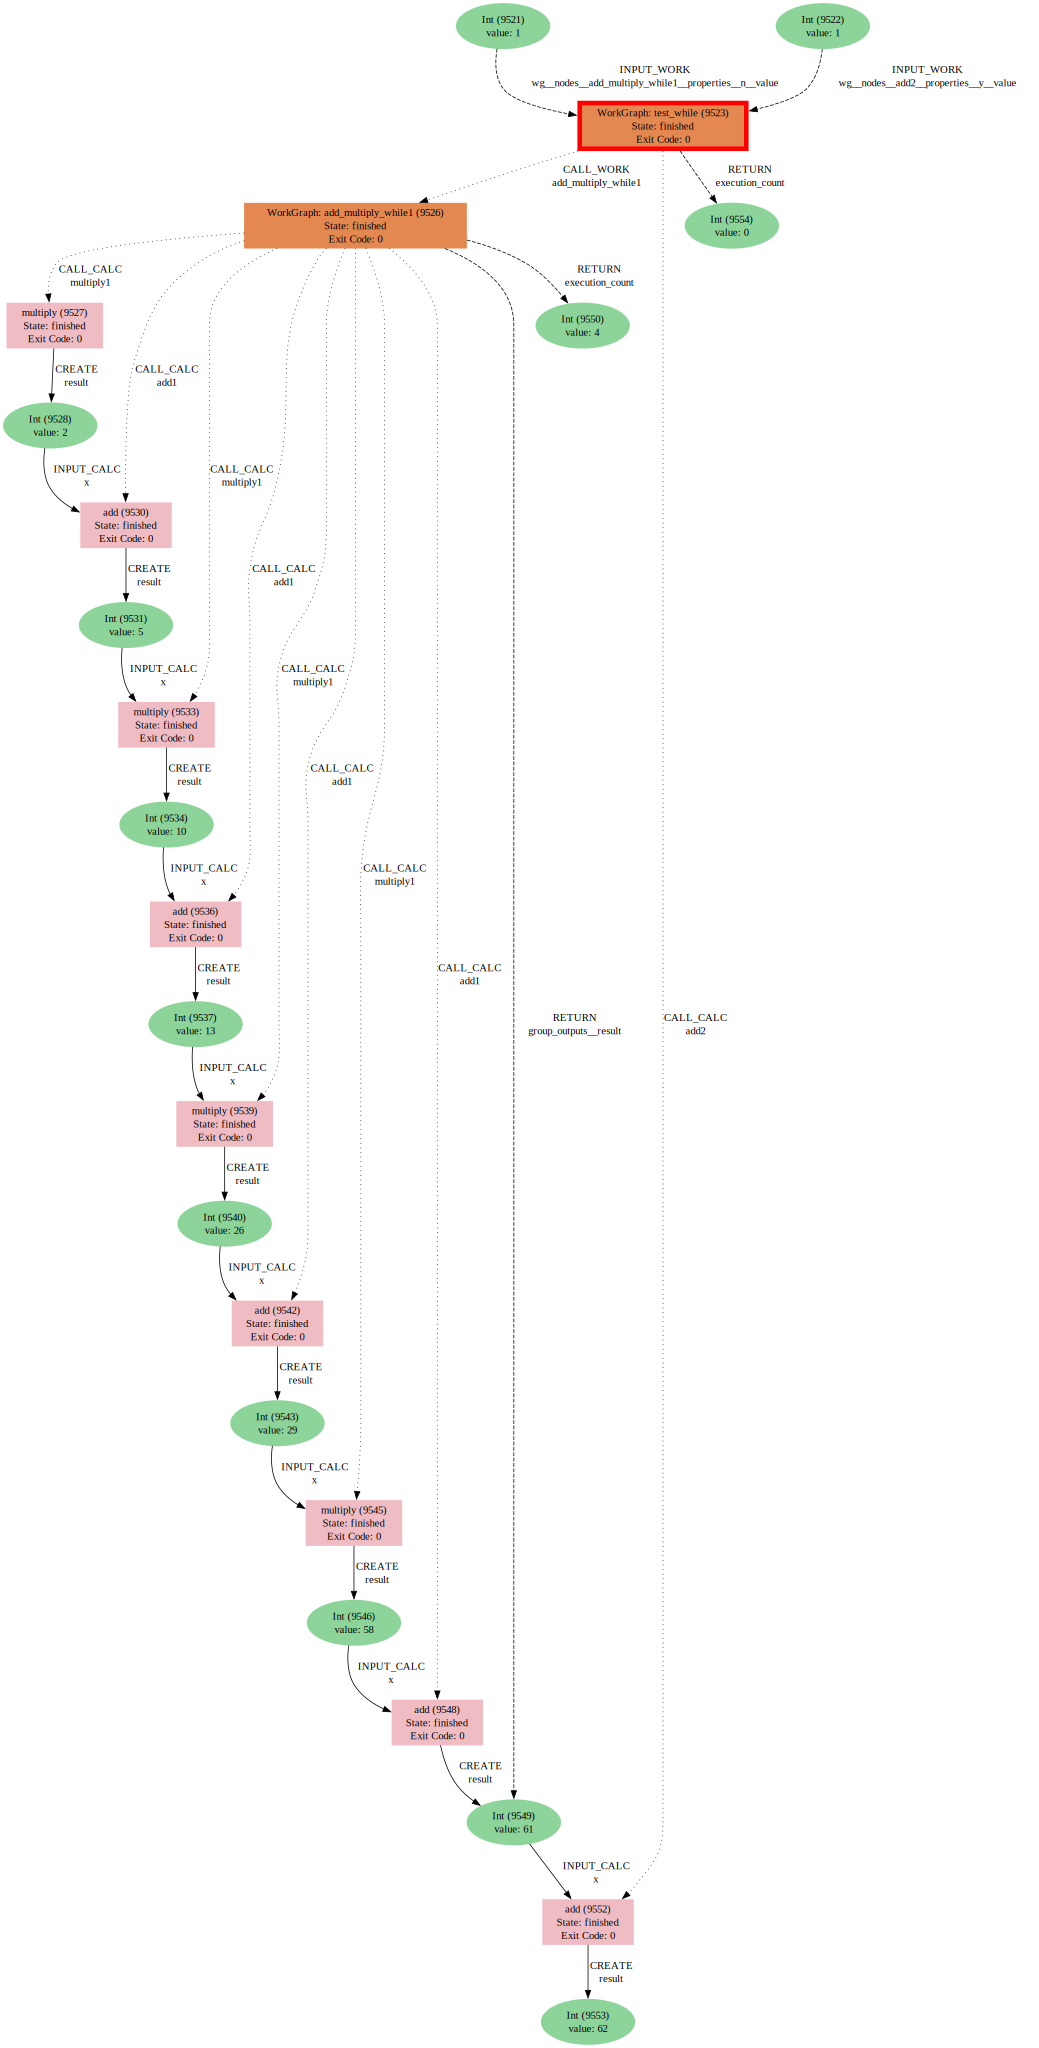

In [5]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

### Max iteration
One can set the maximum number of execution times (`max_iteration`) for the `While` WorkGraph.

In [ ]:
wg = WorkGraph()
wg.workgraph_type = "WHILE"
wg.max_iterations = 10